In [1]:
import numpy as np 
import pandas as pd 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
color = sns.color_palette()
from pandas.tools.plotting import parallel_coordinates
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
print('size of train data',train.shape)
print('size of test data',test.shape)

size of train data (15120, 56)
size of test data (565892, 55)


In [4]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

In [6]:
train["Cover_Type"].value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

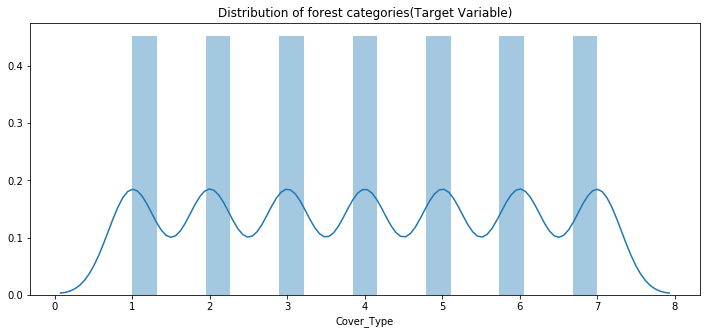

In [7]:
plt.figure(figsize=(12,5))
plt.title("Distribution of forest categories(Target Variable)")
ax = sns.distplot(train["Cover_Type"])

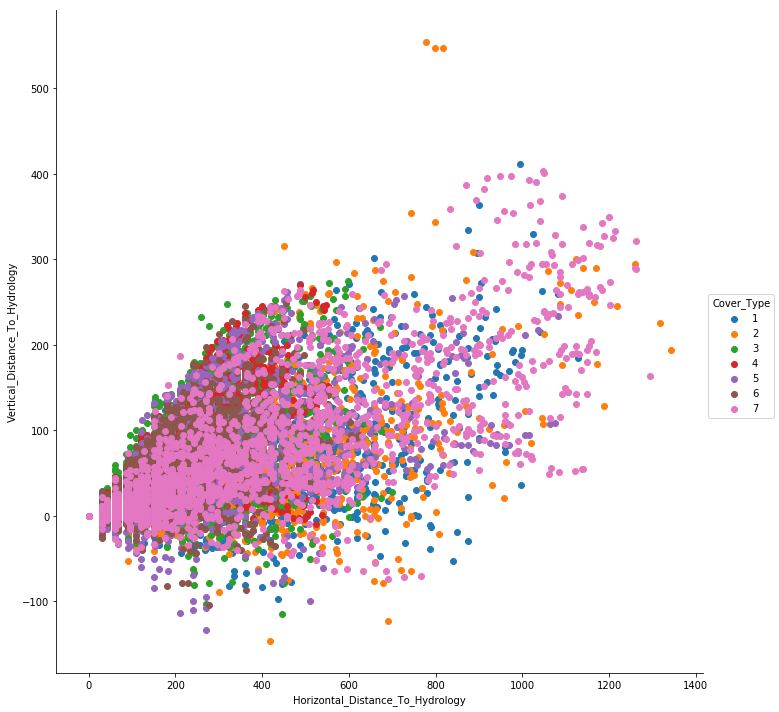

In [8]:
sns.FacetGrid(train, hue="Cover_Type", size=10).map(plt.scatter, "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology").add_legend()

## Principal component analysis (PCA)

Color represent target variable(Cover_type)

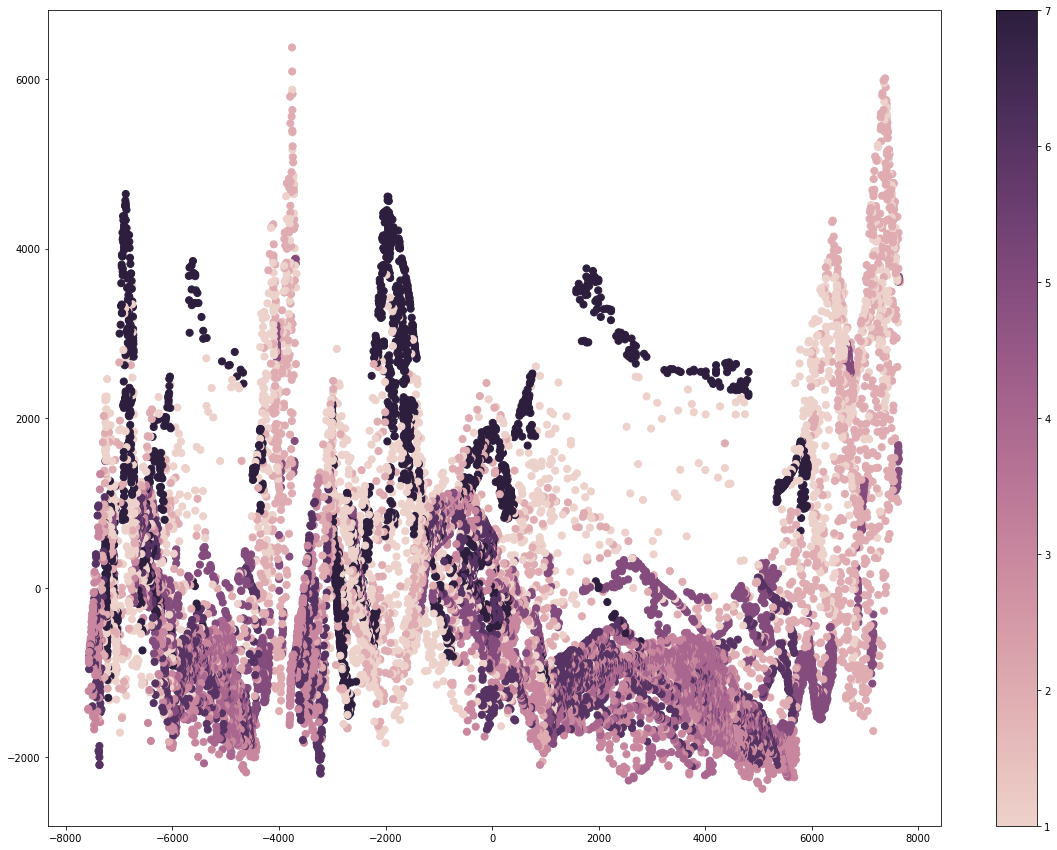

In [9]:
pca = PCA(n_components=4) 
pca_results = pca.fit_transform(train.drop(["Cover_Type"], axis=1))
cmap = sns.cubehelix_palette(as_cmap=True)
tp, ax = plt.subplots(figsize=(20,15))
temp = ax.scatter(pca_results[:,0], pca_results[:,1], c=train.Cover_Type, s=50, cmap=cmap)
tp.colorbar(temp)
plt.show()

# Feature Engineering

* **Features engeneering** :
    * **Linear combination** :
           * Elevation, Vertical dist. to Hydrology
           * Horizontal dist. to Hydrology, Horizontal dist. to Fire Points 
           * Horizontal dist. to Hydrology, Horizontal dist. to Roadways 
           * Horizontal dist. to Fire Points, Horizontal dist. to Roadways 
    * **Euclidean distance** : 
            * Horizontal dist. to Hydrology, Vertical dist. to Hydrology
            * euclidean distance = \sqrt{(verticaldistance)^2 + (horizontaldistance)^2}\] 
    * **Distance to Amenities** :
         * As we know distances to amenities like Water, Fire and Roadways played a key role in determining cover type 
           * Mean distance to Amenities 
           * Mean Distance to Fire and Water 

In [10]:
####################### Train data #############################################
train['HF1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
train['HF2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
train['HR1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
train['HR2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
train['FR1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
train['FR2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
train['ele_vert'] = train.Elevation-train.Vertical_Distance_To_Hydrology

train['slope_hyd'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
train.slope_hyd=train.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

#Mean distance to Amenities 
train['Mean_Amenities']=(train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + train.Horizontal_Distance_To_Roadways) / 3 
#Mean Distance to Fire and Water 
train['Mean_Fire_Hyd']=(train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology) / 2 

####################### Test data #############################################
test['HF1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']
test['HF2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])
test['HR1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])
test['HR2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])
test['FR1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])
test['FR2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])
test['ele_vert'] = test.Elevation-test.Vertical_Distance_To_Hydrology

test['slope_hyd'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5
test.slope_hyd=test.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

#Mean distance to Amenities 
test['Mean_Amenities']=(test.Horizontal_Distance_To_Fire_Points + test.Horizontal_Distance_To_Hydrology + test.Horizontal_Distance_To_Roadways) / 3 
#Mean Distance to Fire and Water 
test['Mean_Fire_Hyd']=(test.Horizontal_Distance_To_Fire_Points + test.Horizontal_Distance_To_Hydrology) / 2

# Model Building

In [11]:
feature = [col for col in train.columns if col not in ['Cover_Type','Id']]#dropping Id anc Cover type.
X_train = train[feature]
X_test = test[feature]

In [12]:
from sklearn.feature_selection import RFECV
etc = ensemble.ExtraTreesClassifier(n_estimators=350)  
selector = RFECV(etc,cv=2)
selector.fit(X_train, train['Cover_Type'])
optimized_columns = X_train.columns[selector.support_]

In [13]:
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 50


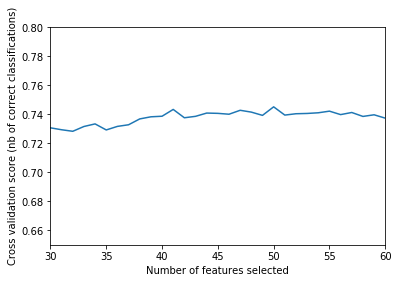

In [14]:
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.xlim(30,60)
plt.ylim(0.65,0.8)
plt.show()

In [15]:
etc = ensemble.ExtraTreesClassifier(n_estimators=350)  
etc.fit(X_train[optimized_columns], train['Cover_Type'])
etc_pred=etc.predict(X_test[optimized_columns])

## Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()

In [19]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {"n_estimators": [100],
                    "max_depth": [5],
                   "min_samples_leaf": [2],
                   "min_samples_split": [3],
}

grid = GridSearchCV(gbc,param_grid=hyperparameters,cv=5)
grid.fit(X_train, train['Cover_Type'])
best_gbc = grid.best_estimator_
gbc_pred=best_gbc.predict(X_test)

In [20]:
from sklearn.ensemble import AdaBoostClassifier
abc= ensemble.AdaBoostClassifier(ensemble.ExtraTreesClassifier(n_estimators=500), n_estimators=250, learning_rate=0.01, algorithm='SAMME')  
abc.fit(X_train, train['Cover_Type'])
abc_pred=abc.predict(X_test)

In [22]:
from xgboost import XGBClassifier
xgb= XGBClassifier(max_depth=15, n_estimators=500)  
xgb.fit(X_train, train['Cover_Type'])
xgb_pred=xgb.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [23]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=2000, max_depth=15)
lgbm.fit(X_train, train['Cover_Type'])
lgbm_pred=lgbm.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [25]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='hinge')
sgd.fit(X_train, train['Cover_Type'])


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [26]:
ens = ensemble.AdaBoostClassifier(ensemble.GradientBoostingClassifier(n_estimators=1000, max_depth=10), n_estimators=1000, learning_rate=0.01, algorithm="SAMME")
ens.fit(X_train, train['Cover_Type'])


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          learning_rate=0.01, n_estimators=1000, random_state=None)

In [27]:
preds = pd.DataFrame()
preds["Extra Trees"] = etc_pred
preds['Gradient Boosting'] =gbc_pred
preds['Ada Boost']= abc_pred
preds['XGB']=xgb_pred
preds['LGBM']=lgbm_pred
preds["SGD"] = sgd.predict(X_test)
preds["Ensemble"] = ens.predict(X_test)

In [28]:
pred = preds.mode(axis=1)
pred

,0,1,2
0,1.0,NaN,NaN
1,1.0,NaN,NaN
2,1.0,NaN,NaN
3,1.0,NaN,NaN
4,1.0,NaN,NaN
5,1.0,NaN,NaN
6,1.0,NaN,NaN
7,1.0,NaN,NaN
8,1.0,NaN,NaN
9,1.0,NaN,NaN


In [29]:
sub = pd.DataFrame({"Id": test['Id'],"Cover_Type": pred[0].astype('int').values})
sub.to_csv("sub.csv", index=False)